### 초기 경로 설정 (클래스 이용을 위함)

In [13]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [14]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [15]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [16]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:0


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [17]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [18]:
train_images = glob.glob('/data/segmentation/Kvasir-SEG/trainset/images/*')
train_labels = glob.glob('/data/segmentation/Kvasir-SEG/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/Kvasir-SEG/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/Kvasir-SEG/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외


train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)


custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))


custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))


My custom training-dataset has 600 elements
My custom valing-dataset has 200 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

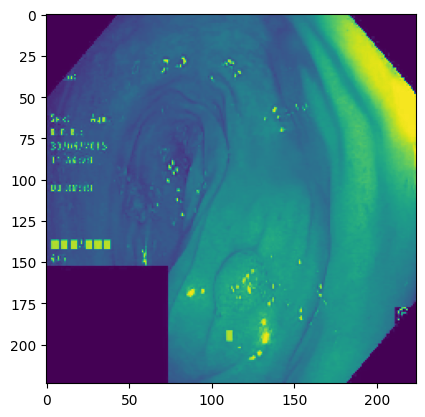

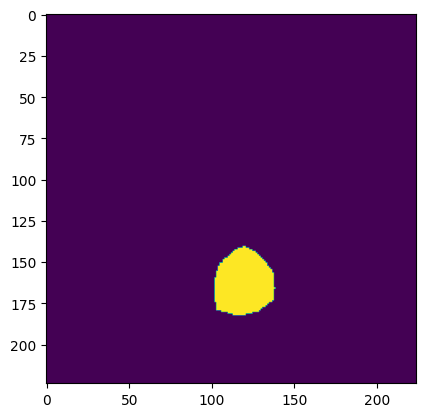

3픽셀의 평균값이라 색깔이 변경됨.


In [19]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [20]:
# Begin training
from models.DeepLab_V3_p.model import DeepLab as DeepLab_V3_p
model = DeepLab_V3_p(backbone = 'resnet', num_classes = 1)   # backbone : 선택 (resnet, xception, mobilenet)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [21]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [22]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'DeepLab_V3+'
data_name = 'Kvasir'

# 5. Training

 Epoch: 1 of 100, Iter.: 75 of 75, Train Loss: 0.804876, IoU: 0.532658, Dice: 0.655984
 Epoch: 1 of 100, Iter.: 75 of 75, Valid Loss: 0.612342, IoU: 0.641768, Dice: 0.751739

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


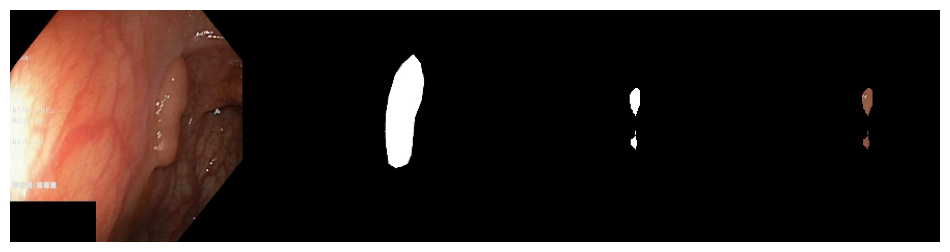

 Epoch: 2 of 100, Iter.: 75 of 75, Train Loss: 0.370948, IoU: 0.732038, Dice: 0.827545
 Epoch: 2 of 100, Iter.: 75 of 75, Valid Loss: 0.451085, IoU: 0.713435, Dice: 0.810222


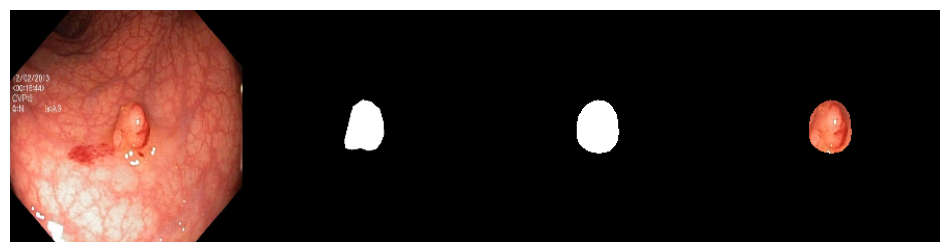

 Epoch: 3 of 100, Iter.: 75 of 75, Train Loss: 0.252694, IoU: 0.790386, Dice: 0.869573
 Epoch: 3 of 100, Iter.: 75 of 75, Valid Loss: 0.341467, IoU: 0.742630, Dice: 0.828002


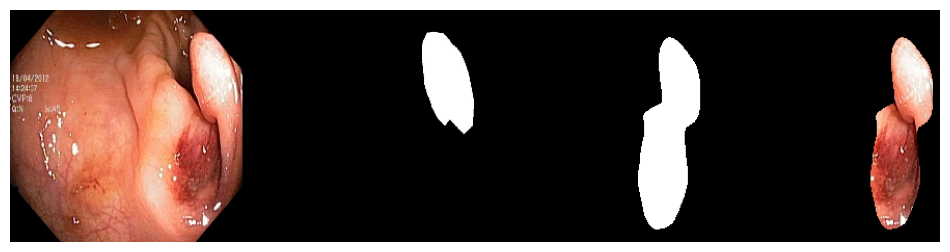

 Epoch: 4 of 100, Iter.: 75 of 75, Train Loss: 0.186371, IoU: 0.832457, Dice: 0.899464
 Epoch: 4 of 100, Iter.: 75 of 75, Valid Loss: 0.350420, IoU: 0.743137, Dice: 0.831555


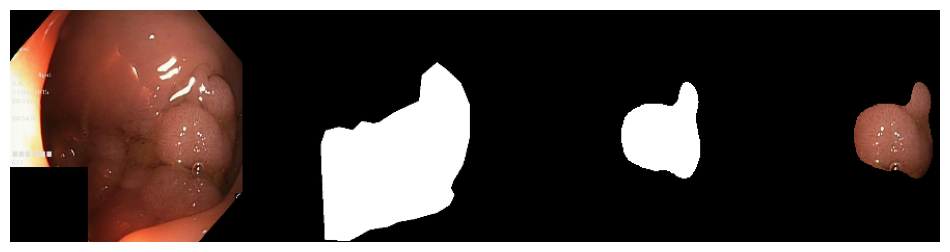

 Epoch: 5 of 100, Iter.: 75 of 75, Train Loss: 0.152955, IoU: 0.853719, Dice: 0.912414
 Epoch: 5 of 100, Iter.: 75 of 75, Valid Loss: 0.328421, IoU: 0.759435, Dice: 0.841677


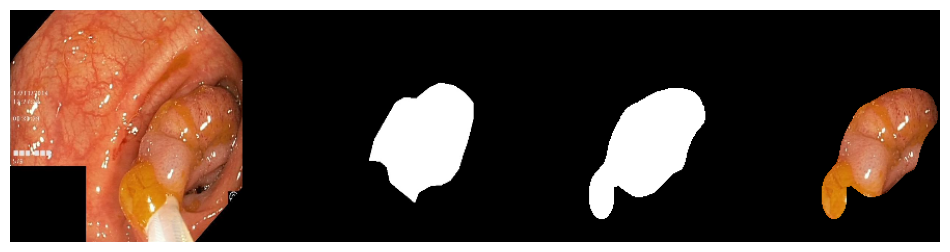

 Epoch: 6 of 100, Iter.: 75 of 75, Train Loss: 0.123607, IoU: 0.873567, Dice: 0.926132
 Epoch: 6 of 100, Iter.: 75 of 75, Valid Loss: 0.351684, IoU: 0.765104, Dice: 0.843770


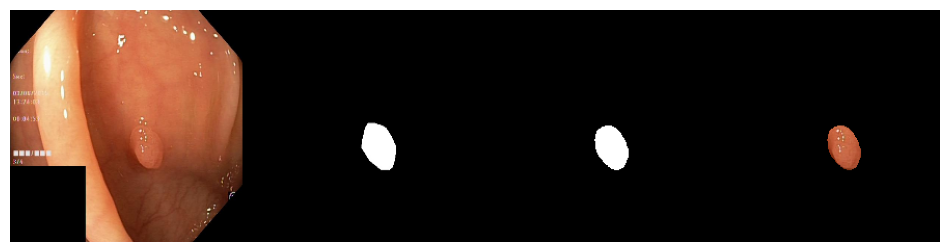

 Epoch: 7 of 100, Iter.: 75 of 75, Train Loss: 0.103990, IoU: 0.887688, Dice: 0.934954
 Epoch: 7 of 100, Iter.: 75 of 75, Valid Loss: 0.330066, IoU: 0.765407, Dice: 0.846445


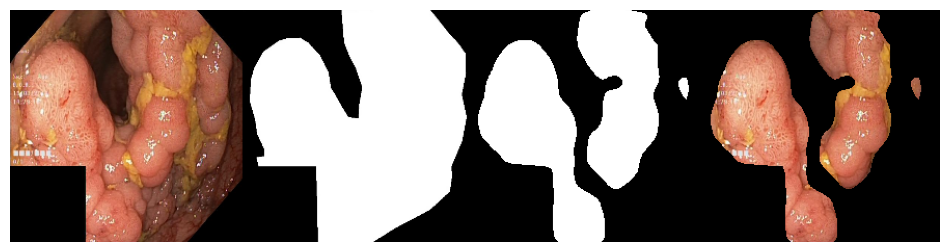

 Epoch: 8 of 100, Iter.: 75 of 75, Train Loss: 0.086310, IoU: 0.904381, Dice: 0.946492
 Epoch: 8 of 100, Iter.: 75 of 75, Valid Loss: 0.312666, IoU: 0.780937, Dice: 0.860116


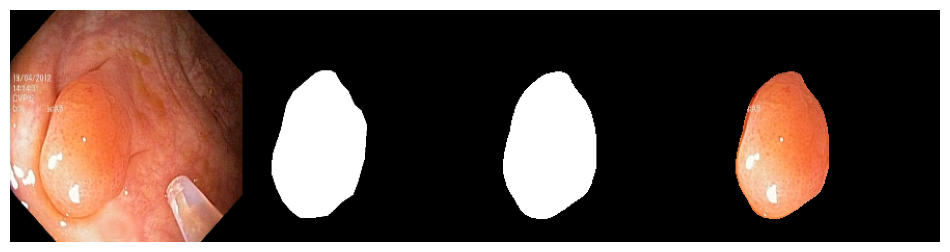

 Epoch: 9 of 100, Iter.: 75 of 75, Train Loss: 0.076768, IoU: 0.911112, Dice: 0.949819
 Epoch: 9 of 100, Iter.: 75 of 75, Valid Loss: 0.306594, IoU: 0.790428, Dice: 0.866490


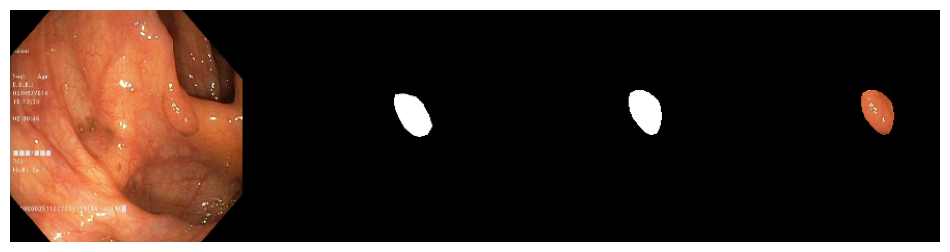

 Epoch: 10 of 100, Iter.: 75 of 75, Train Loss: 0.069176, IoU: 0.918024, Dice: 0.953745
 Epoch: 10 of 100, Iter.: 75 of 75, Valid Loss: 0.338280, IoU: 0.780258, Dice: 0.855396


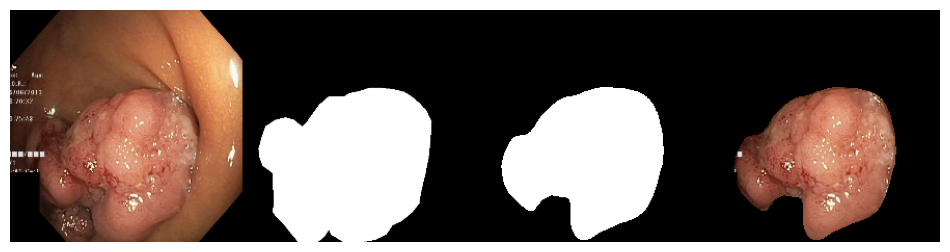

 Epoch: 11 of 100, Iter.: 75 of 75, Train Loss: 0.062172, IoU: 0.923879, Dice: 0.957399
 Epoch: 11 of 100, Iter.: 75 of 75, Valid Loss: 0.358310, IoU: 0.774910, Dice: 0.848916


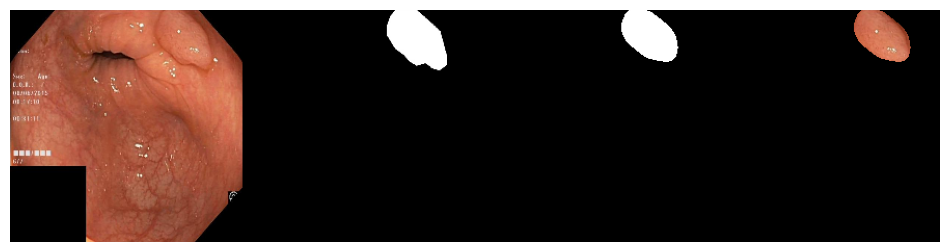

 Epoch: 12 of 100, Iter.: 75 of 75, Train Loss: 0.057671, IoU: 0.928662, Dice: 0.960718
 Epoch: 12 of 100, Iter.: 75 of 75, Valid Loss: 0.348817, IoU: 0.781642, Dice: 0.855556


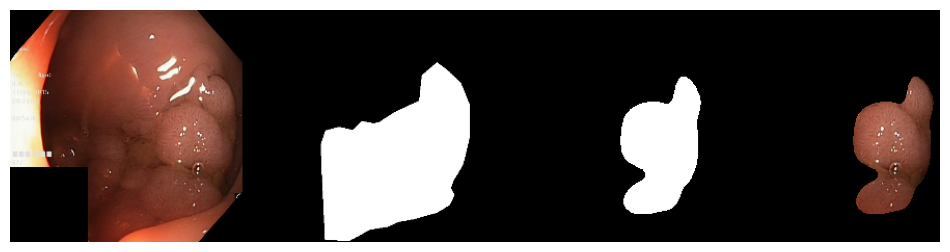

 Epoch: 13 of 100, Iter.: 75 of 75, Train Loss: 0.053721, IoU: 0.934123, Dice: 0.964575
 Epoch: 13 of 100, Iter.: 75 of 75, Valid Loss: 0.338295, IoU: 0.789941, Dice: 0.865422


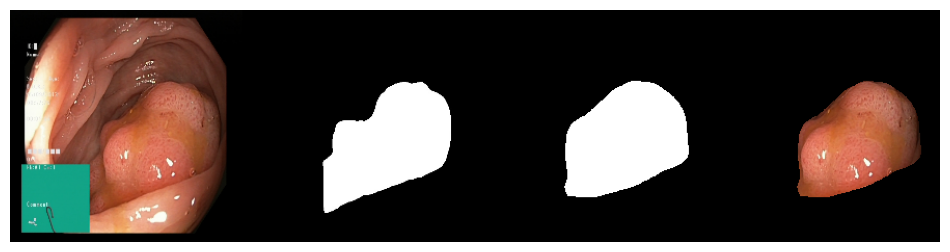

 Epoch: 14 of 100, Iter.: 75 of 75, Train Loss: 0.049342, IoU: 0.938481, Dice: 0.966739
 Epoch: 14 of 100, Iter.: 75 of 75, Valid Loss: 0.345004, IoU: 0.793864, Dice: 0.867574


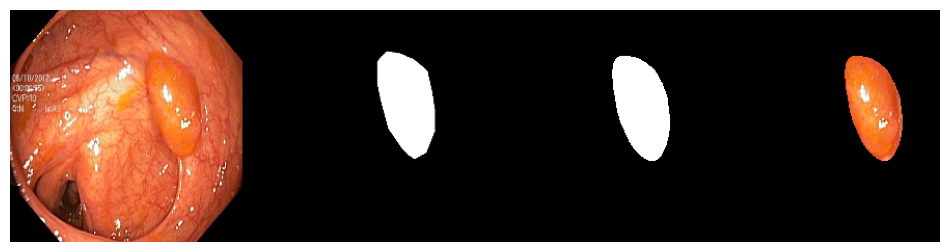

 Epoch: 15 of 100, Iter.: 75 of 75, Train Loss: 0.054030, IoU: 0.933575, Dice: 0.964513
 Epoch: 15 of 100, Iter.: 75 of 75, Valid Loss: 0.414352, IoU: 0.760667, Dice: 0.842082


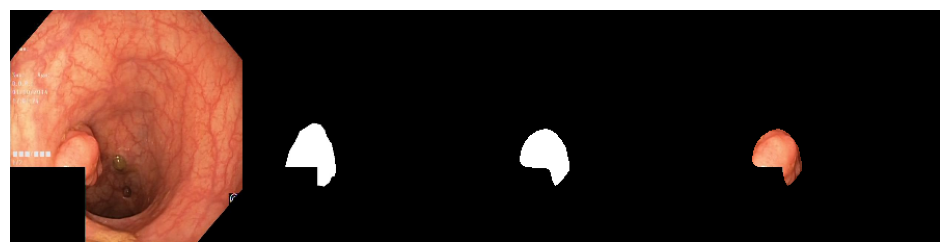

 Epoch: 16 of 100, Iter.: 75 of 75, Train Loss: 0.056091, IoU: 0.928303, Dice: 0.960735
 Epoch: 16 of 100, Iter.: 75 of 75, Valid Loss: 0.393264, IoU: 0.772322, Dice: 0.852245


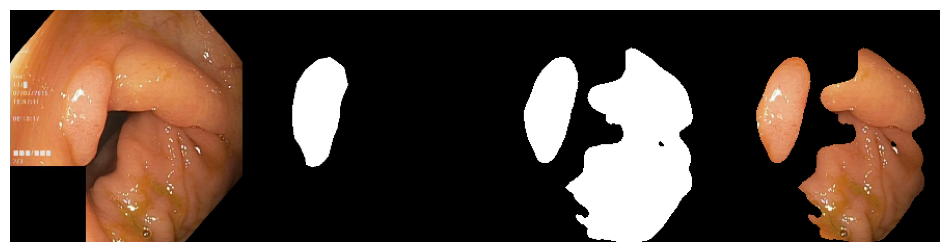

 Epoch: 17 of 100, Iter.: 75 of 75, Train Loss: 0.051873, IoU: 0.935254, Dice: 0.964832
 Epoch: 17 of 100, Iter.: 75 of 75, Valid Loss: 0.372960, IoU: 0.779031, Dice: 0.854862


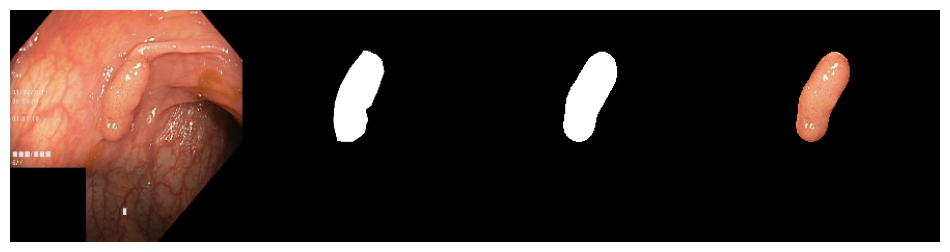

 Epoch: 18 of 100, Iter.: 75 of 75, Train Loss: 0.045900, IoU: 0.942616, Dice: 0.969126
 Epoch: 18 of 100, Iter.: 75 of 75, Valid Loss: 0.357707, IoU: 0.791811, Dice: 0.865342


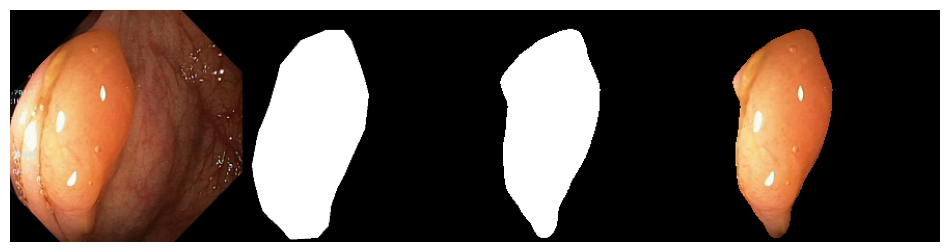

 Epoch: 19 of 100, Iter.: 75 of 75, Train Loss: 0.081685, IoU: 0.913345, Dice: 0.949717
 Epoch: 19 of 100, Iter.: 75 of 75, Valid Loss: 0.577062, IoU: 0.716981, Dice: 0.810524


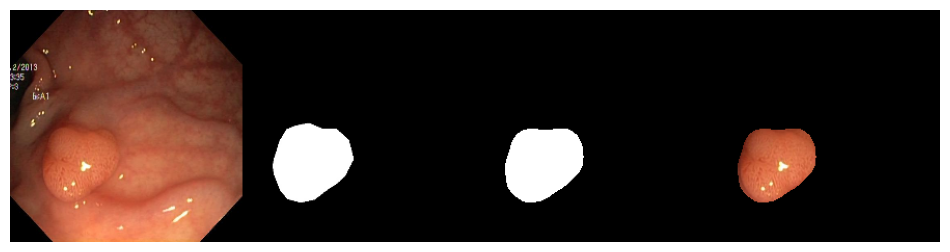

 Epoch: 20 of 100, Iter.: 75 of 75, Train Loss: 0.259645, IoU: 0.789974, Dice: 0.865024
 Epoch: 20 of 100, Iter.: 75 of 75, Valid Loss: 0.527970, IoU: 0.675457, Dice: 0.777305


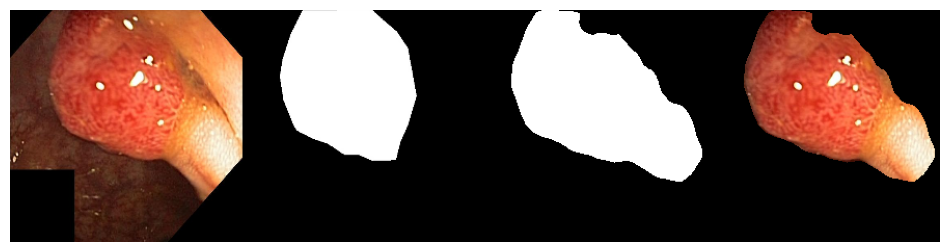

 Epoch: 21 of 100, Iter.: 75 of 75, Train Loss: 0.225496, IoU: 0.807490, Dice: 0.877793
 Epoch: 21 of 100, Iter.: 75 of 75, Valid Loss: 0.385101, IoU: 0.734509, Dice: 0.815859


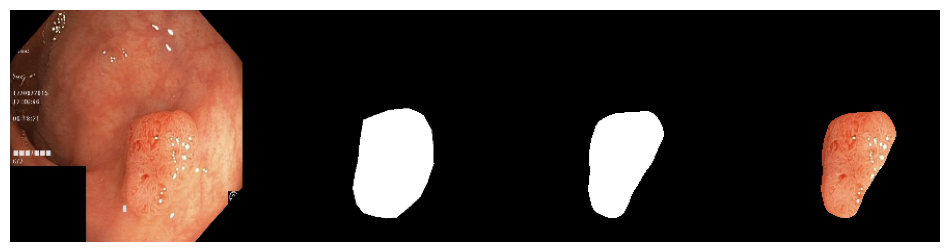

 Epoch: 22 of 100, Iter.: 75 of 75, Train Loss: 0.122979, IoU: 0.876899, Dice: 0.928551
 Epoch: 22 of 100, Iter.: 75 of 75, Valid Loss: 0.326010, IoU: 0.769381, Dice: 0.845979


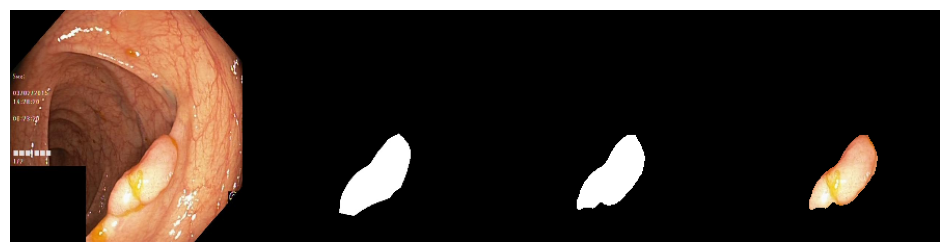

 Epoch: 23 of 100, Iter.: 75 of 75, Train Loss: 0.082886, IoU: 0.903692, Dice: 0.945190
 Epoch: 23 of 100, Iter.: 75 of 75, Valid Loss: 0.360106, IoU: 0.776802, Dice: 0.849390


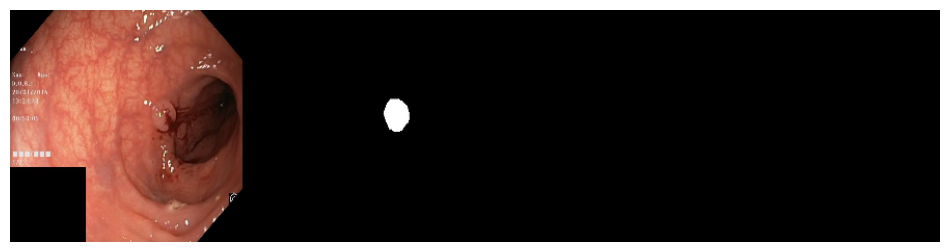

 Epoch: 24 of 100, Iter.: 75 of 75, Train Loss: 0.061439, IoU: 0.924858, Dice: 0.958964
 Epoch: 24 of 100, Iter.: 75 of 75, Valid Loss: 0.373071, IoU: 0.781753, Dice: 0.852324


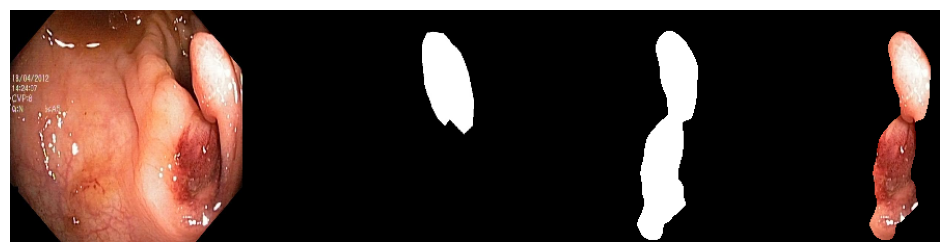

 Epoch: 25 of 100, Iter.: 75 of 75, Train Loss: 0.052507, IoU: 0.934936, Dice: 0.964872
 Epoch: 25 of 100, Iter.: 75 of 75, Valid Loss: 0.354964, IoU: 0.792560, Dice: 0.861273


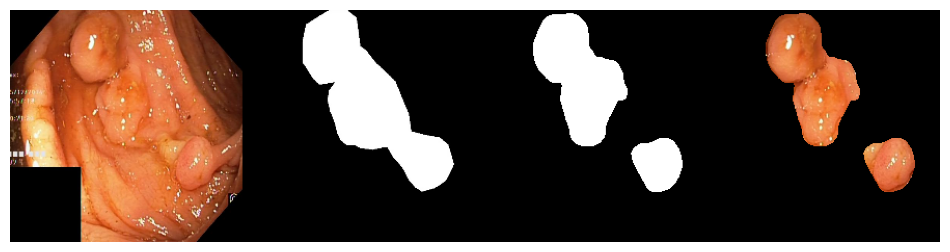

 Epoch: 26 of 100, Iter.: 75 of 75, Train Loss: 0.045229, IoU: 0.942950, Dice: 0.969295
 Epoch: 26 of 100, Iter.: 75 of 75, Valid Loss: 0.360657, IoU: 0.793209, Dice: 0.861934


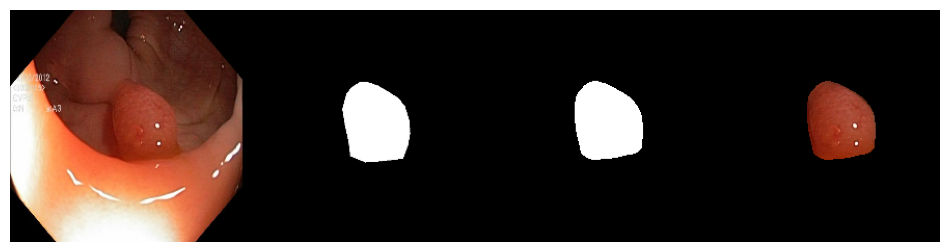

 Epoch: 27 of 100, Iter.: 75 of 75, Train Loss: 0.054253, IoU: 0.935143, Dice: 0.964872
 Epoch: 27 of 100, Iter.: 75 of 75, Valid Loss: 0.399926, IoU: 0.773835, Dice: 0.845042


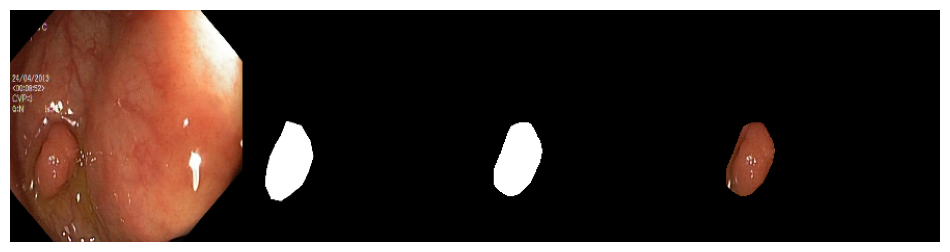

 Epoch: 28 of 100, Iter.: 75 of 75, Train Loss: 0.074200, IoU: 0.919216, Dice: 0.955124
 Epoch: 28 of 100, Iter.: 75 of 75, Valid Loss: 0.376429, IoU: 0.772423, Dice: 0.847393


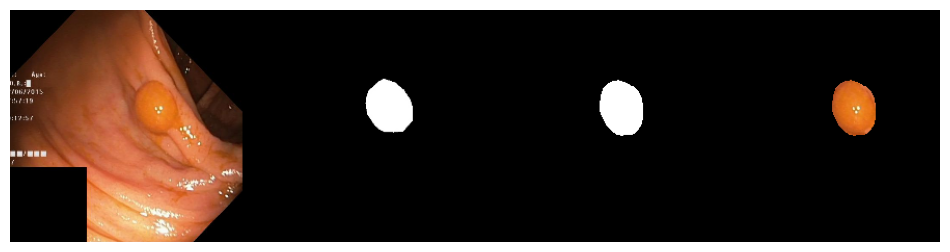

 Epoch: 29 of 100, Iter.: 75 of 75, Train Loss: 0.066609, IoU: 0.916803, Dice: 0.953118
 Epoch: 29 of 100, Iter.: 75 of 75, Valid Loss: 0.405196, IoU: 0.770141, Dice: 0.841663


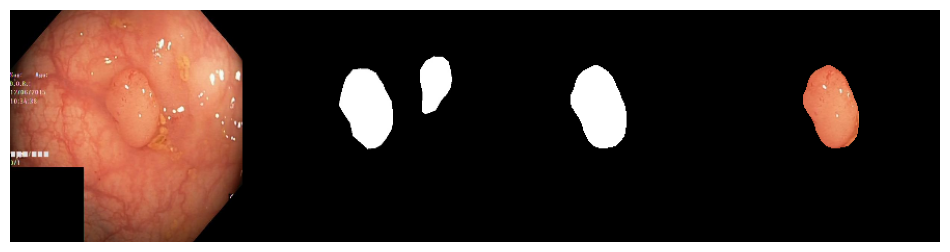

 Epoch: 30 of 100, Iter.: 75 of 75, Train Loss: 0.051583, IoU: 0.936322, Dice: 0.965612
 Epoch: 30 of 100, Iter.: 75 of 75, Valid Loss: 0.525030, IoU: 0.734006, Dice: 0.816164


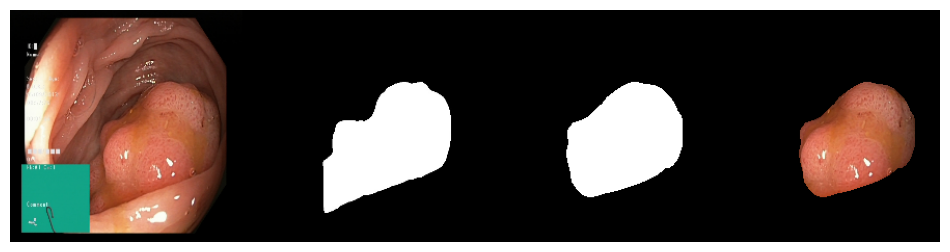

 Epoch: 31 of 100, Iter.: 75 of 75, Train Loss: 0.044597, IoU: 0.940866, Dice: 0.967980
 Epoch: 31 of 100, Iter.: 75 of 75, Valid Loss: 0.399957, IoU: 0.779999, Dice: 0.852162


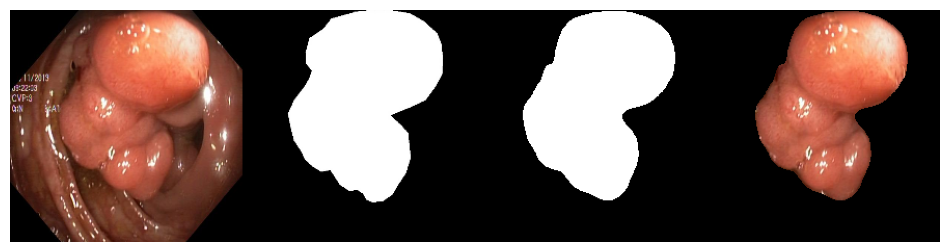

 Epoch: 32 of 100, Iter.: 75 of 75, Train Loss: 0.038670, IoU: 0.948698, Dice: 0.972363
 Epoch: 32 of 100, Iter.: 75 of 75, Valid Loss: 0.407954, IoU: 0.780495, Dice: 0.852498


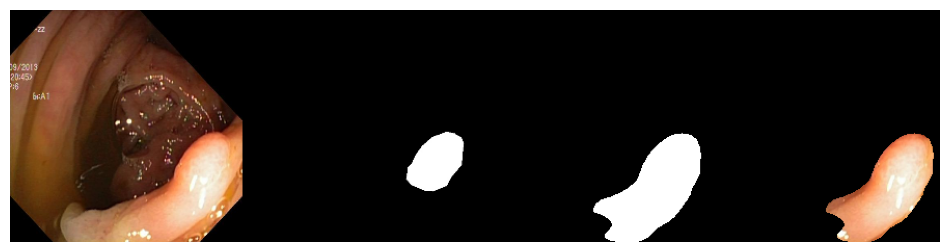

 Epoch: 33 of 100, Iter.: 75 of 75, Train Loss: 0.036774, IoU: 0.951924, Dice: 0.974755
 Epoch: 33 of 100, Iter.: 75 of 75, Valid Loss: 0.415832, IoU: 0.787476, Dice: 0.857515


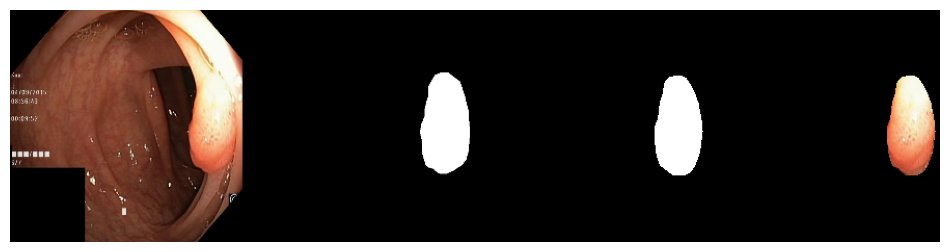

 Epoch: 34 of 100, Iter.: 75 of 75, Train Loss: 0.034620, IoU: 0.953790, Dice: 0.975110
 Epoch: 34 of 100, Iter.: 75 of 75, Valid Loss: 0.444780, IoU: 0.783096, Dice: 0.855667


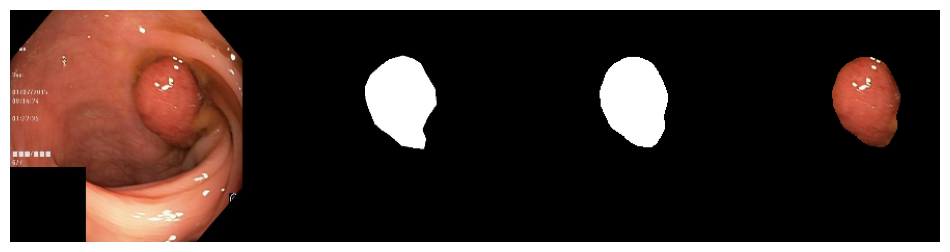

 Epoch: 35 of 100, Iter.: 75 of 75, Train Loss: 0.033768, IoU: 0.954645, Dice: 0.975569
 Epoch: 35 of 100, Iter.: 75 of 75, Valid Loss: 0.441514, IoU: 0.780329, Dice: 0.850771


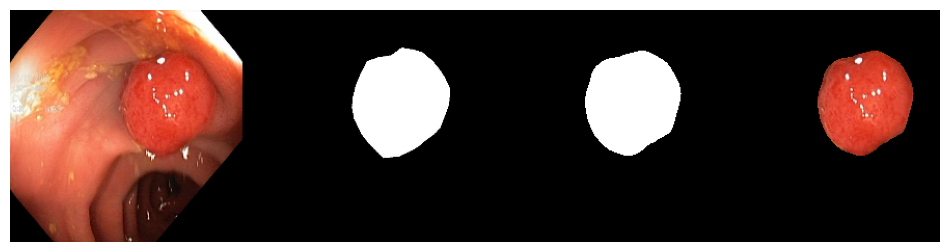


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 7min 16s, sys: 4min 26s, total: 11min 42s
Wall time: 8min 49s


In [23]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:14, Best_IOU:0.7939, Best_DiceScore:0.8676


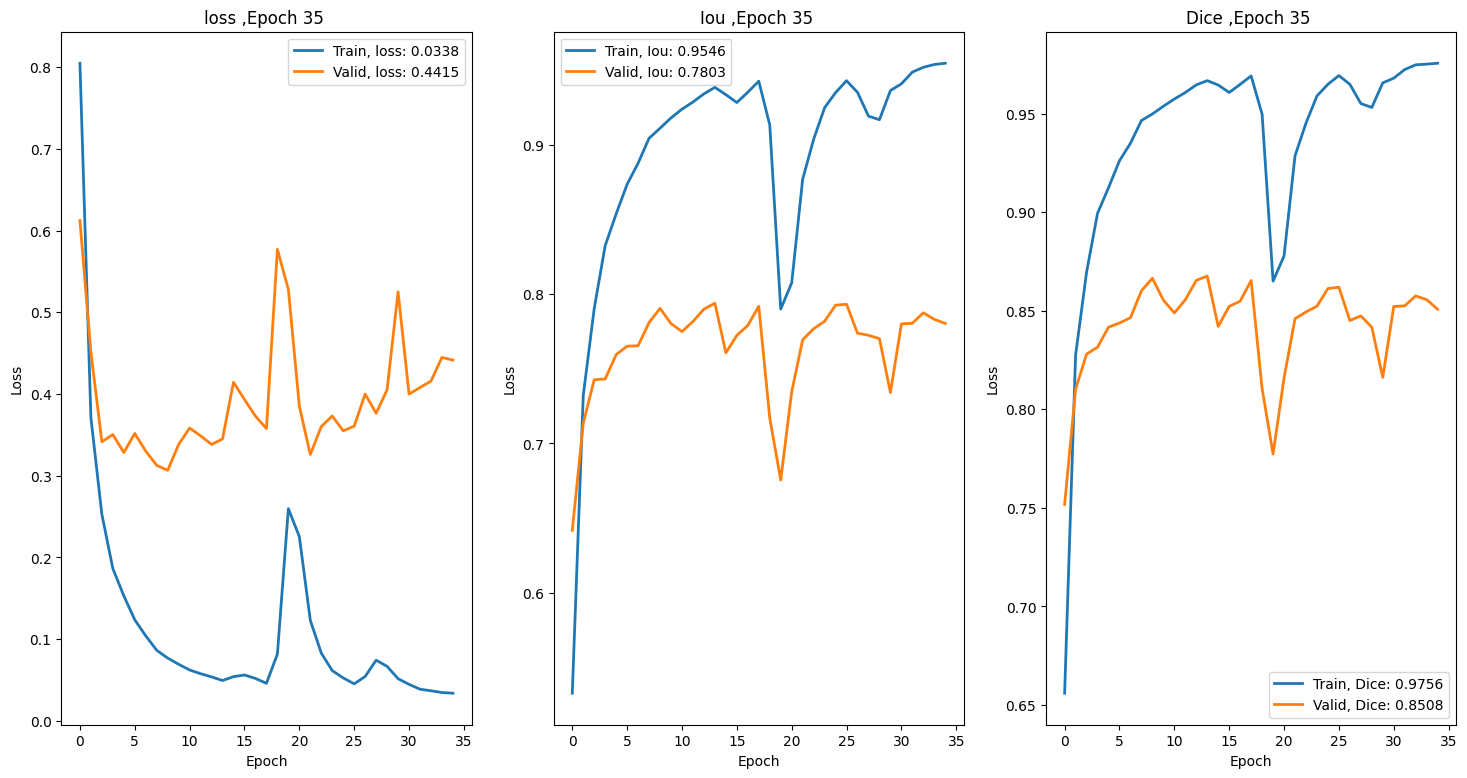

In [24]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()